In [ ]:
!pip install pysindy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 kB 1.2 MB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib_metadata 8.0.0
    Uninstalling importlib_metadata-8.0.0:
      Successfully uninstalled importlib_metadata-8.0.0


In [ ]:
import pandas as pd
import numpy as np
import pysindy as ps


#df_y = pd.read_csv('displacement_time_series_csv')  # Assuming this contains y (amplitude) data
df_q = pd.read_csv('q_time_series_csv')  # Assuming this contains q (control variable) data
df_u = pd.read_csv('u_time_series_csv')  # Assuming this contains u (q_dot) data


print("Dimensions - Y:", "Q:", df_q.shape, "U:", df_u.shape)

# Align data
min_rows = min(df_q.shape[0], df_u.shape[0])
#df_y = df_y.iloc[:min_rows]
df_q = df_q.iloc[:min_rows]
df_u = df_u.iloc[:min_rows]


#Y = df_y.values.flatten().reshape(-1, 1)
Q = df_q.values.flatten().reshape(-1, 1)
U = df_u.values.flatten().reshape(-1, 1)


X_train = np.hstack([Q, U])





dt = 0.01


feature_names = ['q', 'u']


differentiation_method = ps.FiniteDifference(order=2)


optimizer = ps.STLSQ(threshold=0.1)


polynomial_library = ps.PolynomialLibrary(degree=5)
fourier_library = ps.FourierLibrary(n_frequencies=5)
combined_library = polynomial_library + fourier_library

# Initialize SINDy model
model = ps.SINDy(feature_names=feature_names, optimizer=optimizer,
                 differentiation_method=differentiation_method, feature_library=combined_library)

# Fit the model
model.fit(X_train, t=dt)

# Print the model
model.print()


Dimensions - Y: Q: (99999, 1) U: (99999, 1)
(q)' = 17.639 u + -0.894 u^3 + -8.559 sin(1 u) + 0.504 sin(2 u)
(u)' = -8.202 q + 2.947 u + -0.237 q^3 + -2.950 q^2 u + -1.853 sin(1 q)


In [ ]:
df_q.shape

(99999, 1)

In [ ]:
df_u.shape

(99999, 1)

In [ ]:
import pandas as pd
import numpy as np
import pysindy as ps


#df_y = pd.read_csv('displacement_time_series_csv')
df_q = pd.read_csv('q_time_series_csv')
#df_u = pd.read_csv('u_time_series_csv')


print("Dimensions - Y:", "Q:", df_q.shape, "U:", df_u.shape)

# Align data
min_rows = min(df_q.shape[0], df_u.shape[0])
#df_y = df_y.iloc[:min_rows]
df_q = df_q.iloc[:min_rows]
#df_u = df_u.iloc[:min_rows]


#Y = df_y.values.flatten().reshape(-1, 1)
Q = df_q.values.flatten().reshape(-1, 1)
#U = df_u.values.flatten().reshape(-1, 1)


X_train = np.hstack([Q])





dt = 0.01


feature_names = ['q']


differentiation_method = ps.FiniteDifference(order=2)


optimizer = ps.STLSQ(threshold=0.1)


polynomial_library = ps.PolynomialLibrary(degree=5)
fourier_library = ps.FourierLibrary(n_frequencies=5)
combined_library = polynomial_library + fourier_library


model = ps.SINDy(feature_names=feature_names, optimizer=optimizer,
                 differentiation_method=differentiation_method, feature_library=combined_library)

model.fit(X_train, t=dt)


model.print()


Dimensions - Y: Q: (99999, 1) U: (99999, 1)
(q)' = 1999.777 1 + 8.775 q + -894.298 q^2 + -1.043 q^3 + 48.700 q^4 + -9.732 sin(1 q) + -2082.102 cos(1 q) + 0.501 sin(2 q) + 90.642 cos(2 q) + -9.186 cos(3 q) + 0.934 cos(4 q)


In [ ]:
def q_dot_prime(q, q_dot):
    return (0.074
            + 0.400 * q
            + 29.462 * q_dot
            + -0.018 * q**2
            + 0.005 * q * q_dot
            + -0.017 * q_dot**2
            + 0.002 * q**3
            + 0.089 * q**2 * q_dot
            + -0.397 * q * q_dot**2
            + 0.025 * q_dot**3)

def u_dot_prime(q, q_dot):
    return (0.016
            + -32.394 * q
            + 9.744 * q_dot
            + -0.004 * q**2
            + 0.002 * q * q_dot
            + -0.004 * q_dot**2
            + 0.636 * q**3
            + -8.206 * q**2 * q_dot
            + 0.797 * q * q_dot**2
            + -0.455 * q_dot**3)


Max amplitude for Ur = 4.7: 0.0059502410468238245


<ipython-input-10-2a7944a4affe>:36: RuntimeWarning: divide by zero encountered in scalar divide
  phi = -np.arctan(((2 * xi * delta + gamma / mu) * omega) / (delta ** 2 - omega ** 2))


Max amplitude for Ur = 5.0: 0.1153986717598401
Max amplitude for Ur = 5.4: 0.006050186847893523


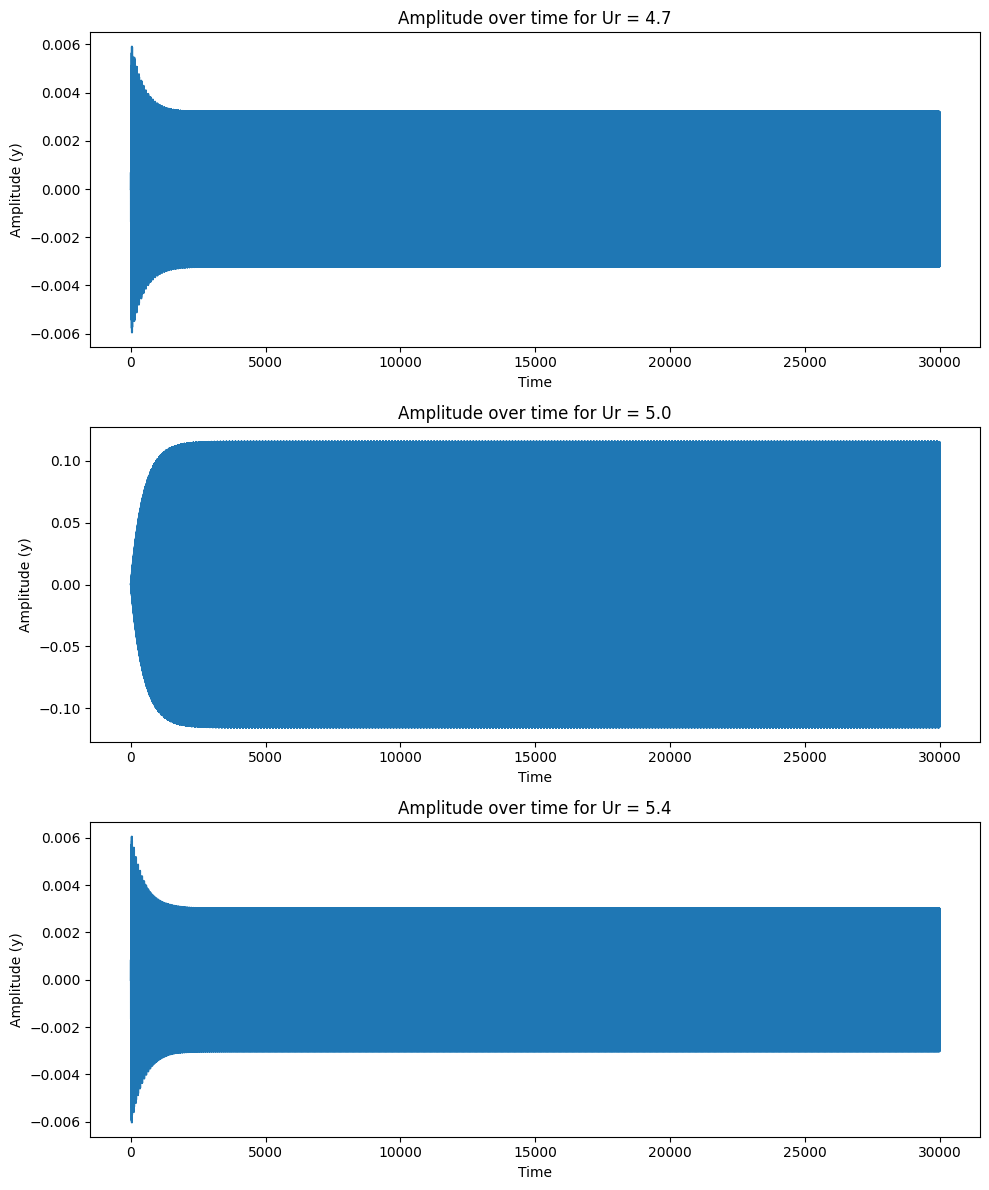

In [ ]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

# Constants
St = 0.2
M = 2.43e-4
mu = 195.56
gamma = 0.8
epsilon = 0.3
A = 12
xi = 0.013 / mu
AM = A * M

# Bicubic equation
def bi_cubic_eq(omega, delta, xi, gamma, mu, AM):
    C = (2 * xi * delta + gamma / mu) ** 2
    G = AM * (delta ** 2 - omega ** 2)

    term1 = omega ** 6
    term2 = -(1 + 2 * delta ** 2 - C) * omega ** 4
    term3 = -(-2 * delta ** 2 + C - delta ** 4) * omega ** 2
    term4 = -delta ** 4 + G

    return term1 + term2 + term3 + term4


def calculate_parameters(Ur):
    delta = 1 / (St * Ur)
    omega_roots = fsolve(lambda omega: bi_cubic_eq(omega, delta, xi, gamma, mu, AM), 1.0)
    omega = omega_roots[0]
    C = (2 * xi * delta + gamma / mu) ** 2
    q_0 = 2 * (1 + (AM * C) / (epsilon * (delta ** 2 - omega ** 2) ** 2 + (2 * xi * delta + (gamma / mu)) ** 2 * omega ** 2))
    y_0 = q_0 * (M * ((delta ** 2 - omega ** 2) ** 2 + (2 * xi * delta + gamma / mu) ** 2 * omega ** 2)) ** 0.5
    phi = -np.arctan(((2 * xi * delta + gamma / mu) * omega) / (delta ** 2 - omega ** 2))
    return delta, omega, q_0, y_0, phi


def q_dot_prime(q, q_dot):
    return (0.074
            + 0.400 * q
            + 29.462 * q_dot
            - 0.018 * q**2
            + 0.005 * q * q_dot
            - 0.017 * q_dot**2
            + 0.002 * q**3
            + 0.089 * q**2 * q_dot
            - 0.397 * q * q_dot**2
            + 0.025 * q_dot**3)

def u_dot_prime(q, q_dot):
    return (0.016
            - 32.394 * q
            + 9.744 * q_dot
            - 0.004 * q**2
            + 0.002 * q * q_dot
            - 0.004 * q_dot**2
            + 0.636 * q**3
            - 8.206 * q**2 * q_dot
            + 0.797 * q * q_dot**2
            - 0.455 * q_dot**3)

# Define the coupled ODE system
def coupled_ode(state, t, xi, delta, M, q_0, y_0, omega, phi, gamma, mu, epsilon, A):
    y, v, q, q_dot = state
    s = M * q_0 * np.sin(omega * t + phi)
    f = -A * omega**2 * y_0 * np.cos(omega * t)

    y_dot = v
    v_dot = s - (2 * xi * delta + (gamma / mu)) * v - delta ** 2 * y
    q_prime = q_dot_prime(q, q_dot)
    u_prime = u_dot_prime(q, q_dot)

    return [y_dot, v_dot, q_prime, u_prime]

# Time points
t_points = np.linspace(0, 30000, 100000)

# Ur values
Ur_values = [4.7, 5.0, 5.4]

# Initialize the plot
fig, axs = plt.subplots(len(Ur_values), 1, figsize=(10, 12))

q_series = []
q_dot_series = []

# Iterate over each Ur value
for i, Ur in enumerate(Ur_values):
    delta, omega, q_0, y_0, phi = calculate_parameters(Ur)
    initial_state = [0, 0, 0, 0]
    solution = odeint(coupled_ode, initial_state, t_points, args=(xi, delta, M, q_0, y_0, omega, phi, gamma, mu, epsilon, A))
    y_t = solution[:, 0]
    max_amplitude = np.max(np.abs(y_t))
    q_t = solution[:, 2]
    q_dot_t = solution[:, 3]
    q_series.append(q_t)
    q_dot_series.append(q_dot_t)

    # Plot the amplitude over time
    axs[i].plot(t_points, y_t)
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Amplitude (y)')
    axs[i].set_title(f'Amplitude over time for Ur = {Ur}')

    print(f"Max amplitude for Ur = {Ur}: {max_amplitude}")

plt.tight_layout()
plt.show()


In [ ]:
'''
    return (
        1999.777 * 1 +
        8.775 * q +
        -894.298 * q**2 +
        -1.043 * q**3 +
        48.700 * q**4 +
        -9.732 * np.sin(1 * q) +
        -2082.102 * np.cos(1 * q) +
        0.501 * np.sin(2 * q) +
        90.642 * np.cos(2 * q) +
        -9.186 * np.cos(3 * q) +
        0.934 * np.cos(4 * q)
    )

    '''



'''

   return (
        -20.681 * np.sin(q)
        + 0.850 * np.sin(q_dot)
        + 5.419 * np.sin(2 * q)
        - 8.804 * np.sin(2 * q_dot)
        - 3.873 * np.sin(3 * q)
        + 4.113 * np.sin(3 * q_dot)
        + 1.731 * np.sin(4 * q)
        - 1.026 * np.sin(4 * q_dot)
        - 0.225 * np.sin(5 * q)
    )
    '''
'''
    return (0.003 + -1.853 * np.sin(q)
        - 8.202 * q
        + 2.947 * q_dot
        - 0.237 * q**3
        - 2.950 * q**2 * q_dot)
        '''










'''

-738.071 * np.sin(q) + 47.945 * np.cos(q)
        - 24.340 * np.sin(q_dot) + 8.591 * np.cos(q_dot)
        + 66.822 * np.sin(2 * q) - 8.532 * np.cos(2 * q)
        + 2.142 * np.sin(2 * q_dot) - 1.658 * np.cos(2 * q_dot)
        - 11.165 * np.sin(3 * q) + 2.067 * np.cos(3 * q)
        - 0.343 * np.sin(3 * q_dot) + 0.442 * np.cos(3 * q_dot)
        + 1.893 * np.sin(4 * q) - 0.447 * np.cos(4 * q)
        + 0.046 * np.sin(4 * q_dot) - 0.127 * np.cos(4 * q_dot)
        - 0.215 * np.sin(5 * q) + 0.059 * np.cos(5 * q)
        - 0.012 * np.sin(5 * q_dot) + 0.019 * np.cos(5 * q_dot)
        - 48.415 - 621.369 * q + 23.931 * q_dot
        + 13.378 * q**2 + 0.001 * q * q_dot + 2.346 * q_dot**2
        - 68.267 * q**3 - 2.976 * q**2 * q_dot
        + 0.012 * q * q_dot**2 - 2.295 * q_dot**3
        '''




 -738.071 * np.sin(1 * q) + 47.945 * np.cos(1 * q) +
        -24.340 * np.sin(1 * q_dot) + 8.591 * np.cos(1 * q_dot) +
        66.822 * np.sin(2 * q) + -8.532 * np.cos(2 * q) +
        2.142 * np.sin(2 * q_dot) + -1.658 * np.cos(2 * q_dot) +
        -11.165 * np.sin(3 * q) + 2.067 * np.cos(3 * q) +
        -0.343 * np.sin(3 * q_dot) + 0.442 * np.cos(3 * q_dot) +
        1.893 * np.sin(4 * q) + -0.447 * np.cos(4 * q) +
        0.046 * np.sin(4 * q_dot) + -0.127 * np.cos(4 * q_dot) +
        -0.215 * np.sin(5 * q) + 0.059 * np.cos(5 * q) +
        -0.012 * np.sin(5 * q_dot) + 0.019 * np.cos(5 * q_dot) +
        -48.415 * 1 + 621.369 * q + 23.931 * q_dot +
        13.378 * q**2 + 0.001 * q * q_dot + 2.346 * q_dot**2 +
        -68.267 * q**3 + -2.976 * q**2 * q_dot + 0.012 * q * q_dot**2 + -2.295 * q_dot**3

In [ ]:
import pandas as pd
import numpy as np
import pysindy as ps


#df_y = pd.read_csv('displacement_time_series_csv')
df_q = pd.read_csv('q_time_series_data.csv')
df_u = pd.read_csv('q_dot_time_series_neo.csv')


print("Dimensions - Y:", "Q:", df_q.shape, "U:", df_u.shape)

# Align data
min_rows = min(df_q.shape[0], df_u.shape[0])
#df_y = df_y.iloc[:min_rows]
df_q = df_q.iloc[:min_rows]
df_u = df_u.iloc[:min_rows]


#Y = df_y.values.flatten().reshape(-1, 1)
Q = df_q.values.flatten().reshape(-1, 1)
U = df_u.values.flatten().reshape(-1, 1)


X_train = np.hstack([Q, U])





dt = 0.01


feature_names = ['q', 'u']


differentiation_method = ps.FiniteDifference(order=2)


optimizer = ps.STLSQ(threshold=0)


polynomial_library = ps.PolynomialLibrary(degree=3)
#fourier_library = ps.FourierLibrary(n_frequencies=5)
combined_library = polynomial_library


model = ps.SINDy(feature_names=feature_names, optimizer=optimizer,
                 differentiation_method=differentiation_method, feature_library=combined_library)

model.fit(X_train, t=dt)


model.print()


Dimensions - Y: Q: (299999, 1) U: (299999, 1)
(q)' = 0.074 1 + 0.400 q + 29.462 u + -0.018 q^2 + 0.005 q u + -0.017 u^2 + 0.002 q^3 + 0.089 q^2 u + -0.397 q u^2 + 0.025 u^3
(u)' = 0.016 1 + -32.394 q + 9.744 u + -0.004 q^2 + 0.002 q u + -0.004 u^2 + 0.636 q^3 + -8.206 q^2 u + 0.797 q u^2 + -0.455 u^3


In [ ]:
!pip install pysindy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 kB 2.4 MB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib_metadata 8.0.0
    Uninstalling importlib_metadata-8.0.0:
      Successfully uninstalled importlib_metadata-8.0.0


In [ ]:
# Uninstall the current version of importlib-metadata
!pip uninstall -y importlib-metadata

# Install the compatible version of importlib-metadata
!pip install importlib-metadata==7.2.1


Found existing installation: importlib_metadata 7.2.1
Uninstalling importlib_metadata-7.2.1:
  Successfully uninstalled importlib_metadata-7.2.1
  Using cached importlib_metadata-7.2.1-py3-none-any.whl (25 kB)


In [ ]:
import pandas as pd
import numpy as np
import pysindy as ps

# Load data from the CSV file
df = pd.read_csv('qu_solution_Ur_5.csv')

# Extract q and u values
q_values = df['q'].values.reshape(-1, 1)
u_values = df['u'].values.reshape(-1, 1)

# Combine q and u into X_train for PySINDy
X_train = np.hstack([q_values, u_values])

# Time step (assuming uniform time series data)
dt = 0.01

# Feature names
feature_names = ['q', 'u']

# Differentiation method
differentiation_method = ps.FiniteDifference(order=2)

# Optimizer
optimizer = ps.STLSQ(threshold=0)

# Feature library (polynomial in this case)
polynomial_library = ps.PolynomialLibrary(degree=3)

# Initialize the SINDy model
model = ps.SINDy(feature_names=feature_names, optimizer=optimizer,
                 differentiation_method=differentiation_method, feature_library=polynomial_library)

# Fit the model to the data
model.fit(X_train, t=dt)

# Print the model equations
model.print()


(q)' = 0.161 q + 29.359 u + 0.009 q^3 + 0.021 q^2 u + -0.053 q u^2 + 0.005 u^3
(u)' = 0.003 1 + -30.844 q + 4.356 u + 0.072 q^3 + -1.048 q^2 u + -0.108 q u^2 + 0.129 u^3


In [ ]:
import pandas as pd
import numpy as np
import pysindy as ps

# Load data from the CSV file
df = pd.read_csv('qu_solution_Ur_5.csv')

# Extract q and u values
q_values = df['q'].values.reshape(-1, 1)
u_values = df['u'].values.reshape(-1, 1)

# Combine q and u into X_train for PySINDy
X_train = np.hstack([q_values, u_values])

# Time step (assuming uniform time series data)
dt = 0.3

# Feature names
feature_names = ['q', 'u']

# Differentiation method
differentiation_method = ps.FiniteDifference(order=2)

# Optimizer
optimizer = ps.STLSQ(threshold=0)

# Feature library (polynomial in this case)
polynomial_library = ps.FourierLibrary(n_frequencies=2)

# Initialize the SINDy model
model = ps.SINDy(feature_names=feature_names, optimizer=optimizer,
                 differentiation_method=differentiation_method, feature_library=polynomial_library)

# Fit the model to the data
model.fit(X_train, t=dt)

# Print the model equations
model.print()


(q)' = 0.171 sin(1 q) + -2.477 sin(1 u) + 0.099 sin(2 q) + -1.116 sin(2 u)
(u)' = 3.240 sin(1 q) + -0.794 sin(1 u) + -0.076 sin(2 q) + 1.249 sin(2 u)


In [ ]:
np.savetxt('Normalised_csv_file', df_normalized, delimiter = ',')

In [ ]:
import pandas as pd
import numpy as np
import pysindy as ps


df = pd.read_csv('Normalised_csv_file_2')


q_values = df.iloc[:, 1].values.reshape(-1, 1)
u_values = df.iloc[:, 2].values.reshape(-1, 1)


X_train = np.hstack([q_values, u_values])


dt = 0.3


feature_names = ['q', 'u']


differentiation_method = ps.FiniteDifference(order=2)


optimizer = ps.STLSQ(threshold=0.1)


polynomial_library = ps.PolynomialLibrary(degree = 3)


model = ps.SINDy(feature_names=feature_names, optimizer=optimizer,
                 differentiation_method=differentiation_method, feature_library=polynomial_library)


model.fit(X_train, t=dt)


model.print()


(q)' = 1.052 u
(u)' = -0.902 q + 0.145 u + -0.935 q^2 u + -0.170 q u^2 + 0.137 u^3


In [ ]:
import pandas as pd
import numpy as np
import pysindy as ps

# Load data from the CSV file
df = pd.read_csv('Normalised_csv_file_2')

# Extract q and u values
q_values = df.iloc[:, 1].values.reshape(-1, 1)
u_values = df.iloc[:, 2].values.reshape(-1, 1)

# Combine q and u into X_train for PySINDy
X_train = np.hstack([q_values, u_values])

# Time step (assuming uniform time series data)
dt = 0.3

# Feature names
feature_names = ['q', 'u']

# Differentiation method
differentiation_method = ps.FiniteDifference(order=2)

# Optimizer
optimizer = ps.STLSQ(threshold=0.1)

# Feature library (polynomial in this case)
polynomial_library = ps.FourierLibrary(n_frequencies = 3)
#polynomial_library = ps.PolynomialLirary(degree = 3)

# Initialize the SINDy model
model = ps.SINDy(feature_names=feature_names, optimizer=optimizer,
                 differentiation_method=differentiation_method, feature_library=polynomial_library)

# Fit the model to the data
model.fit(X_train, t=dt)

# Print the model equations
model.print()


(q)' = 1.447 sin(1 u) + -0.193 sin(2 u)
(u)' = -2.632 sin(1 q) + 2.165 sin(1 u) + 1.539 sin(2 q) + -1.686 sin(2 u) + -0.673 sin(3 q) + 0.132 sin(3 u)
